In [351]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import sys
sys.path.insert(0, '/mnt/home/raheppt1/projects/age_prediction')
import numpy as np
import datetime
from pathlib import Path
import matplotlib.pyplot as plt

# tensorflow-gpu 2.0.0
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, Conv2D
from tensorflow.keras.layers import BatchNormalization, ReLU
from tensorflow.keras.optimizers import *
import tensorflow_probability as tfp
from scipy.ndimage import gaussian_filter

from dataset import AgeData
from misc import utils
from misc.utils import init_gpu
from models.models3d import age_regression

In [352]:
# Initialize GPU 
init_gpu(gpu_device='0')

2.0.0
1 Physical GPUs, 1 Logical GPUs


In [367]:
# Parameters
batch_size = 16
mc_samples = 50
# Switch between test and validation set
select_testset = True
select_dataset = 'IXI'
select_group = 'AD'
select_cv_split = 0
config = {
        # General parameters
        'image_size': [100, 120, 100],
        'image_spacing': [1.5, 1.5, 1.5],
    }

image_size = config['image_size']
image_spacing = config['image_spacing']

if select_dataset == 'IXI':
    # IXI
    config['base_folder'] = '/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/PP_IXIT1'
    config['file_prefix'] = 'fcmnorm_brain_mni_IXI'
    config['file_suffix'] = '_T1_restore'
    config['file_ext'] = '.nii.gz'
    config['path_training_csv'] = f'/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config/IXI_T1_train_split{select_cv_split}.csv'
    config['path_validation_csv'] = f'/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config/IXI_T1_val_split{select_cv_split}.csv'
    config['path_test_csv'] = '/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config/IXI_T1_test.csv'
    config['path_info_csv'] = '/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config/IXI_T1_age.csv'
elif select_dataset == 'ADNI':
    # ADNI
    config['base_folder'] = '/mnt/share/raheppt1/project_data/brain/ADNI/ADNI_T1'
    config['file_prefix'] = 'fcmnorm_brain_mni_ADNI_'
    config['file_suffix'] = '_T1'
    config['file_ext'] = '.nii.gz'
    config['path_training_csv'] = f'/mnt/share/raheppt1/project_data/brain/ADNI/config/GR_{select_group}/{select_group}_ADNI_T1_train_split{select_cv_split}.csv'
    config['path_validation_csv'] = f'/mnt/share/raheppt1/project_data/brain/ADNI/config/GR_{select_group}/{select_group}_ADNI_T1_val_split{select_cv_split}.csv'
    config['path_test_csv'] = f'/mnt/share/raheppt1/project_data/brain/ADNI/config/GR_{select_group}/{select_group}_ADNI_T1_test_complete.csv'
    config['path_info_csv'] = '/mnt/share/raheppt1/project_data/brain/ADNI/config/ADNI_age_only.csv'
            
# Load training and test data.
age_data = AgeData(config,
                   shuffle_training_images=True,
                   save_debug_images=False,
                   select_testset=select_testset)
dataset_train = age_data.dataset_train()
train_samples = dataset_train.num_entries()
dataset_val = age_data.dataset_val()
val_samples = dataset_val.num_entries()
print(train_samples, val_samples)

def disturb(image):
    affine = np.diag((1, 2, 3, 1))
    affine[:3, 3] = 40, 50, 60
    sample = {
        't1': dict(
            #data=np.random.rand(*shape),
            data=image,
            affine=affine,
            type=INTENSITY,
            stem='t1',
        )
    }

    transform = torchio.RandomMotion(
        proportion_to_augment=1.0,
        seed=42,)
    transformed = transform(sample)
    return transformed['t1']['data'].numpy()
    
# Define training and validation datasets from generators.
def train_gen():
    data = dataset_train
    i = 0
    while i < data.num_entries():
        sample = data.get_next()
        # DHWC tensor format
        image = sample['generators']['image'].transpose([1, 2, 3, 0])
        image = image.astype('float32')
        age = sample['generators']['age']
        yield image, age
        i += 1

def val_gen():
    data = dataset_val
    i = 0
    while i < data.num_entries():
        sample = data.get_next()
        image = sample['generators']['image'].transpose([1, 2, 3, 0])
        #image = gaussian_filter(sample['generators']['image'].transpose([1, 2, 3, 0]), sigma=3.0)# (sample['generators']['image']).transpose([1, 2, 3, 0])
        image = np.random.rand(*image.shape)
        image = image.astype('float32')
        age = sample['generators']['age']
        yield image, age
        i += 1

ds_train = tf.data.Dataset.from_generator(train_gen,
                                          output_types=(tf.float32, tf.float32),
                                          output_shapes=(tf.TensorShape((None, None, None, None)),
                                                         tf.TensorShape((1, ))))
ds_train = ds_train.batch(batch_size=batch_size)

ds_val = tf.data.Dataset.from_generator(val_gen,
                                        output_types=(tf.float32, tf.float32),
                                        output_shapes=(tf.TensorShape((None, None, None, None)),
                                                       tf.TensorShape((1, ))))
ds_val = ds_val.batch(batch_size=batch_size)

sample =next(iter(ds_val))

loaded 416 ids
loaded 100 ids
416 100


In [368]:
prior_scale = 1.0
def prior(dtype, shape, name, trainable, add_variable_fn):
    loc = tf.zeros(shape)
    scale = tf.ones(shape) * prior_scale
    prior_dist = tfp.distributions.Normal(loc=loc, scale=scale)
    prior_dist = tfp.distributions.Independent(prior_dist,
                                               reinterpreted_batch_ndims=tf.size(prior_dist.batch_shape_tensor()))
    return prior_dist

bayesian_model = age_regression.build_bayesian_model(image_size + [1],
                                                     prior=prior,
                                                     flipout=False,
                                                     outputs=1)

checkpoint_path = Path('/mnt/share/raheppt1/tf_models/age/keras/new_bayesian_06/')
latest = tf.train.latest_checkpoint(checkpoint_path)
bayesian_model.load_weights(str(latest))

In [369]:
def mean_mae(y_true, y_pred):
    return tf.keras.losses.MAE(y_true[:, 0], y_pred[:, 0])

def mean_mse(y_true, y_pred):
    return tf.keras.losses.MSE(y_true[:, 0], y_pred[:, 0])

preds_list = []
preds_std_list = []
labels_list = []

for test_images, test_labels in ds_val:
    preds = list()
    # Multiple forward runs
    for i in range(mc_samples):
        preds.append(bayesian_model(test_images, training=False))
    preds = tf.stack(preds, axis=0).numpy()
    preds_std = np.quantile(preds, 0.7, axis=0)- np.quantile(preds, 0.3, axis=0)
    preds = np.median(preds, axis=0, keepdims=False)
    preds_list.append(preds)
    preds_std_list.append(preds_std)
    labels_list.append(test_labels)
    print(np.mean(preds_std))
    print(mean_mae(test_labels, preds))
    print(mean_mse(test_labels, preds))
all_labels = tf.concat(labels_list, axis=0)
all_preds = tf.concat(preds_list, axis=0)
all_preds_std = tf.concat(preds_std_list, axis=0)

12.78154430389404
tf.Tensor(16.406235, shape=(), dtype=float32)
tf.Tensor(334.48737, shape=(), dtype=float32)
10.311293411254882
tf.Tensor(13.743126, shape=(), dtype=float32)
tf.Tensor(272.08044, shape=(), dtype=float32)
10.319460034370422
tf.Tensor(12.648846, shape=(), dtype=float32)
tf.Tensor(234.02898, shape=(), dtype=float32)
12.16053602695465
tf.Tensor(14.15053, shape=(), dtype=float32)
tf.Tensor(256.94592, shape=(), dtype=float32)
12.270982241630552
tf.Tensor(15.575453, shape=(), dtype=float32)
tf.Tensor(352.22006, shape=(), dtype=float32)
10.604956531524659
tf.Tensor(15.862093, shape=(), dtype=float32)
tf.Tensor(310.33636, shape=(), dtype=float32)
9.651609516143797
tf.Tensor(12.506779, shape=(), dtype=float32)
tf.Tensor(290.49173, shape=(), dtype=float32)


In [364]:
np.concatenate((all_labels[:20], all_preds[:20],all_preds_std[:20] ), axis=1)

array([[39.17590714, 48.17062378,  7.30770988],
       [41.88911819, 41.30696487,  6.80717278],
       [27.01437378, 40.35113907,  4.88771133],
       [68.13415527, 62.9789505 ,  6.03771629],
       [72.30664062, 61.32040405,  7.43323059],
       [65.40999603, 66.64440918,  6.69139862],
       [59.78371048, 61.29368973,  3.57536774],
       [28.87063599, 34.41512299,  5.21197987],
       [65.09513855, 67.2101593 ,  7.2421051 ],
       [30.18206787, 32.86868286,  4.67473183],
       [23.84667969, 44.95330811,  6.17900009],
       [63.39219666, 56.44483948,  5.06939812],
       [42.22039795, 33.95947266,  4.77729263],
       [63.81656265, 49.16946411,  5.19739876],
       [24.34223175, 24.57886124,  3.21352425],
       [60.0739212 , 55.57462311,  4.81354218],
       [46.22039795, 38.53142548,  5.16861382],
       [72.59411621, 63.74967575,  5.32068596],
       [41.13073349, 45.76815033,  5.07033272],
       [54.21492004, 52.42808151,  5.07810593]])

In [365]:
mean_mae(all_preds, all_labels)

<tf.Tensor: id=9096048, shape=(), dtype=float32, numpy=6.7315764>

In [366]:
np.mean(all_preds_std)

5.075205966949461

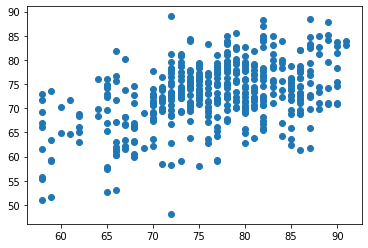

In [350]:
plt.scatter(all_labels, all_preds)

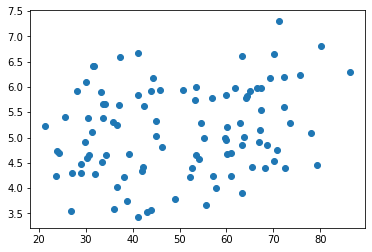

In [215]:
plt.scatter(all_labels, all_preds_std)

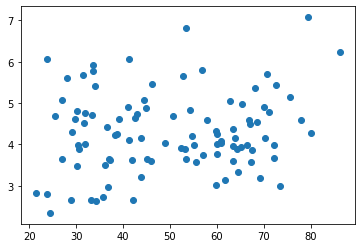

In [170]:
plt.scatter(all_labels, all_preds_std)

In [16]:
import torchio
from torchio import INTENSITY, LABEL, DATA
import numpy as np

(16, 100, 120, 100, 1)


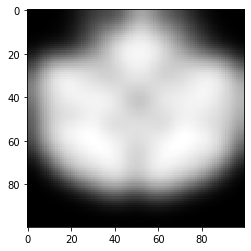

torch.Size([1, 100, 120, 100])


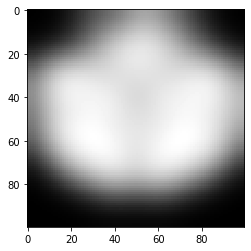

In [149]:
for test_images, test_labels in ds_val:
    print(test_images.shape)
    plt.imshow(test_images[0, :, 50, :,0], cmap='gray')
    plt.show()
    
    shape = 1, 10, 20, 30
    affine = np.diag((1, 2, 3, 1))
    affine[:3, 3] = 40, 50, 60
    sample = {
        't1': dict(
            #data=np.random.rand(*shape),
            data=test_images.numpy(),
            affine=affine,
            type=INTENSITY,
            stem='t1',
        )
    }

    transform = torchio.RandomMotion(
        proportion_to_augment=1.0,
        seed=42,)
    transformed = transform(sample)
    print(transformed['t1']['data'].shape)
    break
from scipy.ndimage import gaussian_filter
filtered = gaussian_filter(test_images[0,...].numpy(), sigma=5.0)

#transformed['t2'][DATA] = transformed['t2'][DATA] - 0.5
#plt.imshow(transformed['t1']['data'][0, :, 50, :], cmap='gray')
plt.imshow(filtered[:, 50, :, 0], cmap='gray')